# DQN Training for Fire-Rescue Environment

#### Deep Q-Network - Value-Based Reinforcement Learning
 
This notebook includes:
 - 10+ hyperparameter configurations
 - Training with different settings
 - Logging and visualization
 - Model saving and evaluation

In [1]:
!pip install gymnasium stable-baselines3 tensorboard matplotlib pandas seaborn tqdm

In [2]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 2: Import Libraries
# ═══════════════════════════════════════════════════════════════════════
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Stable Baselines
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# Add project root to path
project_root = Path.cwd().parent if 'training' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

# Import custom environment
from environment.custom_env import FireRescueEnv

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

print("✓ All libraries imported successfully")
print(f"✓ Project root: {project_root}")

✓ All libraries imported successfully
✓ Project root: c:\Users\HP\Programming\ML\fire_rescue_agent


In [3]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 3: Setup Directories
# ═══════════════════════════════════════════════════════════════════════
"""
Create necessary directories for models and logs
"""
# Create directory structure
base_dir = project_root / "models" / "dqn"
logs_dir = base_dir / "training_logs"
tensorboard_dir = base_dir / "tensorboard"
results_dir = project_root / "results"
plots_dir = results_dir / "plots"

for directory in [base_dir, logs_dir, tensorboard_dir, results_dir, plots_dir]:
    directory.mkdir(parents=True, exist_ok=True)

print("✓ Directories created:")
print(f"  - Models: {base_dir}")
print(f"  - Logs: {logs_dir}")
print(f"  - Tensorboard: {tensorboard_dir}")
print(f"  - Results: {results_dir}")

✓ Directories created:
  - Models: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn
  - Logs: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\training_logs
  - Tensorboard: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard
  - Results: c:\Users\HP\Programming\ML\fire_rescue_agent\results


In [4]:
# ═══════════════════════════════════════════════════════════════════════
# cell 4: DQN HYPERPARAMETER CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
Focused on key hyperparameters mentioned by instructor:
- learning_rate (lr)
- gamma (discount factor)
- batch_size
- epsilon_start (exploration_initial_eps)
- epsilon_end (exploration_final_eps)
- epsilon_decay (exploration_fraction)

Standardized across all configs:
- buffer_size = 50000 (same for all)
- learning_starts = 1000 (same for all)
- tau = 1.0 (hard target network updates)

Network architecture (policy_kwargs):
- Most use [64, 64] (standard)
- Some use [128, 128] (deeper) or [32, 32] (shallower)
"""

DQN_CONFIGS = {
    # ─────────────────────────────────────────────────────────────────────
    # Config 1: BASELINE (Good starting point)
    # ─────────────────────────────────────────────────────────────────────
    "config_1_baseline": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized parameters
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Baseline - Standard settings"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 2: HIGH LEARNING RATE (Too aggressive - may not converge)
    # ─────────────────────────────────────────────────────────────────────
    "config_2_high_lr": {
        "learning_rate": 5e-3,  # Very high
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High LR - Unstable learning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 3: LOW LEARNING RATE (Too slow - won't learn much)
    # ─────────────────────────────────────────────────────────────────────
    "config_3_low_lr": {
        "learning_rate": 1e-5,  # Very low
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low LR - Slow learning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 4: LARGE BATCH (More stable but slower)
    # ─────────────────────────────────────────────────────────────────────
    "config_4_large_batch": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 128,  # Large batch
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Large Batch - Stable gradients"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 5: SMALL BATCH (Noisier but faster)
    # ─────────────────────────────────────────────────────────────────────
    "config_5_small_batch": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 16,  # Small batch
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Small Batch - Fast updates"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 6: LOW GAMMA (Short-sighted - doesn't plan ahead)
    # ─────────────────────────────────────────────────────────────────────
    "config_6_low_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.95,  # Low discount factor
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Gamma - Myopic policy"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 7: HIGH GAMMA (Very forward-looking)
    # ─────────────────────────────────────────────────────────────────────
    "config_7_high_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.995,  # High discount factor
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Gamma - Long-term planning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 8: FAST EXPLORATION DECAY (Stops exploring too soon)
    # ─────────────────────────────────────────────────────────────────────
    "config_8_fast_decay": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.1,  # Higher final epsilon
        "exploration_fraction": 0.1,  # Fast decay
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Fast Decay - Premature exploitation"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 9: SLOW EXPLORATION DECAY (Explores longer)
    # ─────────────────────────────────────────────────────────────────────
    "config_9_slow_decay": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.01,  # Very low final epsilon
        "exploration_fraction": 0.4,  # Slow decay
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Slow Decay - Extended exploration"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 10: OPTIMIZED (Best guess based on task)
    # ─────────────────────────────────────────────────────────────────────
    "config_10_optimized": {
        "learning_rate": 3e-4,  # Sweet spot
        "gamma": 0.99,
        "batch_size": 64,  # Good balance
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.02,
        "exploration_fraction": 0.3,  # Balanced exploration
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[128, 128]),  # Deeper network
        "description": "Optimized - Well-balanced settings"
    },
    
     # ─────────────────────────────────────────────────────────────────────
    # Config 11: Zero epsilon start and end
    # ─────────────────────────────────────────────────────────────────────
    "config_11_low_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.95,
        "batch_size": 32,
        "exploration_initial_eps": 0,
        "exploration_final_eps": 0,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Zero Epsilon - No exploration"
    }
}

# ═══════════════════════════════════════════════════════════════════════
# CONFIGURATION SUMMARY TABLE
# ═══════════════════════════════════════════════════════════════════════
print(f"✓ Defined {len(DQN_CONFIGS)} DQN configurations\n")
print("=" * 100)
print(f"{'Config':<25} {'LR':<10} {'Gamma':<8} {'Batch':<8} {'ε_start':<10} {'ε_end':<10} {'ε_decay':<10} {'Network':<15}")
print("=" * 100)

for config_name, config in DQN_CONFIGS.items():
    net_arch = str(config['policy_kwargs']['net_arch'])
    print(f"{config_name:<25} {config['learning_rate']:<10.0e} {config['gamma']:<8.3f} "
          f"{config['batch_size']:<8} {config['exploration_initial_eps']:<10.2f} "
          f"{config['exploration_final_eps']:<10.2f} {config['exploration_fraction']:<10.2f} {net_arch:<15}")

print("=" * 100)
print("\nKey Insights:")
print("  • Configs 2 & 3: Test extreme learning rates")
print("  • Configs 4 & 5: Test batch size impact")
print("  • Configs 6 & 7: Test discount factor (short vs long-term)")
print("  • Configs 8 & 9: Test exploration strategy")
print("  • Config 10: Optimized combination")
print("\nAll configs use:")
print("  • buffer_size = 50,000 (standardized)")
print("  • learning_starts = 1,000 (standardized)")
print("  • tau = 1.0 (hard target updates)")
print("=" * 100)

✓ Defined 11 DQN configurations

Config                    LR         Gamma    Batch    ε_start    ε_end      ε_decay    Network        
config_1_baseline         1e-03      0.990    32       1.00       0.05       0.20       [64, 64]       
config_2_high_lr          5e-03      0.990    32       1.00       0.05       0.20       [64, 64]       
config_3_low_lr           1e-05      0.990    32       1.00       0.05       0.20       [64, 64]       
config_4_large_batch      1e-03      0.990    128      1.00       0.05       0.20       [64, 64]       
config_5_small_batch      1e-03      0.990    16       1.00       0.05       0.20       [64, 64]       
config_6_low_gamma        1e-03      0.950    32       1.00       0.05       0.20       [64, 64]       
config_7_high_gamma       1e-03      0.995    32       1.00       0.05       0.20       [64, 64]       
config_8_fast_decay       1e-03      0.990    32       1.00       0.10       0.10       [64, 64]       
config_9_slow_decay       1e-03

In [5]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 5: Training Configuration
# ═══════════════════════════════════════════════════════════════════════
"""
Set training parameters (matching PPO for fair comparison)
"""
# Training settings
TOTAL_TIMESTEPS = 100000  # Match PPO training timesteps
EVAL_FREQ = 5000          # Evaluate every N steps
N_EVAL_EPISODES = 10      # Number of episodes for evaluation
SAVE_FREQ = 10000         # Save model checkpoint every N steps

print("Training Configuration:")
print(f"  - Total Timesteps: {TOTAL_TIMESTEPS:,}")
print(f"  - Evaluation Frequency: {EVAL_FREQ:,}")
print(f"  - Evaluation Episodes: {N_EVAL_EPISODES}")
print(f"  - Checkpoint Frequency: {SAVE_FREQ:,}")
print(f"\nNote: Timesteps match PPO training for fair comparison")

Training Configuration:
  - Total Timesteps: 100,000
  - Evaluation Frequency: 5,000
  - Evaluation Episodes: 10
  - Checkpoint Frequency: 10,000

Note: Timesteps match PPO training for fair comparison


In [6]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 6: Training Function
# ═══════════════════════════════════════════════════════════════════════
"""
Function to train a single DQN configuration
"""

def train_dqn_config(config_name, config, total_timesteps=TOTAL_TIMESTEPS):
    """
    Train DQN with given configuration
    
    Args:
        config_name: Name of the configuration
        config: Dictionary of hyperparameters
        total_timesteps: Total training steps
    
    Returns:
        Dictionary with training results
    """
    print(f"\n{'='*70}")
    print(f"Training: {config_name}")
    print(f"Description: {config['description']}")
    print(f"{'='*70}")
    
    # Create environment (matching PPO parameters)
    env = FireRescueEnv(grid_size=10, max_time=200)  # Match PPO max_time
    env = Monitor(env)
    
    # Create eval environment
    eval_env = FireRescueEnv(grid_size=10, max_time=200)
    eval_env = Monitor(eval_env)
    
    # Create model directory for this config
    model_dir = base_dir / config_name
    model_dir.mkdir(exist_ok=True)
    
    # Setup callbacks
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=str(model_dir),
        log_path=str(logs_dir / config_name),
        eval_freq=EVAL_FREQ,
        n_eval_episodes=N_EVAL_EPISODES,
        deterministic=True,
        render=False,
        verbose=1
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=SAVE_FREQ,
        save_path=str(model_dir / "checkpoints"),
        name_prefix="dqn_checkpoint",
        save_replay_buffer=True,
        save_vecnormalize=True
    )
    
    callback_list = CallbackList([eval_callback, checkpoint_callback])
    
    # Extract hyperparameters (remove description)
    train_config = {k: v for k, v in config.items() if k != 'description'}
    
    # Create DQN model
    model = DQN(
        "MlpPolicy",
        env,
        verbose=1,
        seed=SEED,
        tensorboard_log=str(tensorboard_dir / config_name),
        **train_config
    )
    
    # Train
    start_time = datetime.now()
    print(f"\nStarting training at {start_time.strftime('%H:%M:%S')}")
    
    try:
        model.learn(
            total_timesteps=total_timesteps,
            callback=callback_list,
            progress_bar=True
        )
        
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"\n✓ Training completed in {training_time:.1f} seconds")
        
        # Save final model
        final_model_path = model_dir / "final_model"
        model.save(str(final_model_path))
        print(f"✓ Model saved to {final_model_path}")
        
        # Final evaluation (100 episodes to match PPO)
        print("\nFinal evaluation (100 episodes)...")
        mean_reward, std_reward = evaluate_policy(
            model, 
            eval_env, 
            n_eval_episodes=100,
            deterministic=True
        )
        
        # ═══════════════════════════════════════════════════════════════════════
        # Calculate episode metrics (matching PPO)
        # ═══════════════════════════════════════════════════════════════════════
        print(f"Calculating episode performance metrics...")
        episode_rewards = []
        episode_lengths = []
        wall_collision_rates = []
        scan_efficiencies = []
        pickup_attempts_list = []
        time_to_find_survivor_list = []
        
        for episode_num in range(100):
            obs, _ = eval_env.reset()
            done = False
            
            while not done:
                action, _states = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = eval_env.step(action)
                done = terminated or truncated
            
            # Extract metrics from final info
            episode_rewards.append(info.get('episode_length', 0) * -0.01)  # Approximation
            episode_lengths.append(info.get('episode_length', 0))
            wall_collision_rates.append(info.get('wall_collision_rate', 0))
            scan_efficiencies.append(info.get('scan_efficiency', 0))
            pickup_attempts_list.append(info.get('pickup_attempts', 0))
            
            time_found = info.get('time_to_find_survivor', None)
            if time_found is not None:
                time_to_find_survivor_list.append(time_found)
            
            # Debug output for first 5 episodes
            if episode_num < 5:
                print(f"  Episode {episode_num+1}: "
                      f"Steps: {info.get('episode_length', 0)} | "
                      f"Wall Collisions: {info.get('wall_collision_rate', 0):.2%} | "
                      f"Scan Eff: {info.get('scan_efficiency', 0):.2%}")
        
        print(f"\n📊 Evaluation Summary:")
        print(f"   Average Episode Length: {np.mean(episode_lengths):.1f} steps")
        print(f"   Wall Collision Rate: {np.mean(wall_collision_rates):.2%}")
        print(f"   Scan Efficiency: {np.mean(scan_efficiencies):.2%}")
        print(f"   Avg Pickup Attempts: {np.mean(pickup_attempts_list):.2f}")
        if time_to_find_survivor_list:
            print(f"   Avg Time to Find Survivor: {np.mean(time_to_find_survivor_list):.1f} steps ({len(time_to_find_survivor_list)}/100 found)")
        
        # Store results (matching PPO format)
        results = {
            'config_name': config_name,
            'description': config['description'],
            'mean_reward': mean_reward,
            'std_reward': std_reward,
            'avg_episode_length': np.mean(episode_lengths),
            'wall_collision_rate': np.mean(wall_collision_rates),
            'scan_efficiency': np.mean(scan_efficiencies),
            'avg_pickup_attempts': np.mean(pickup_attempts_list),
            'avg_time_to_find_survivor': float(np.mean(time_to_find_survivor_list)) if time_to_find_survivor_list else None,
            'survivor_found_count': len(time_to_find_survivor_list),
            'training_time': training_time,
            'total_timesteps': total_timesteps,
            'hyperparameters': train_config
        }
        
        # Save results to JSON
        results_file = model_dir / "results.json"
        with open(results_file, 'w') as f:
            json_results = {
                'config_name': config_name,
                'description': config['description'],
                'mean_reward': float(mean_reward),
                'std_reward': float(std_reward),
                'avg_episode_length': float(np.mean(episode_lengths)),
                'wall_collision_rate': float(np.mean(wall_collision_rates)),
                'scan_efficiency': float(np.mean(scan_efficiencies)),
                'avg_pickup_attempts': float(np.mean(pickup_attempts_list)),
                'avg_time_to_find_survivor': float(np.mean(time_to_find_survivor_list)) if time_to_find_survivor_list else None,
                'survivor_found_count': len(time_to_find_survivor_list),
                'training_time': float(training_time),
                'total_timesteps': total_timesteps,
                'hyperparameters': {
                    k: (float(v) if isinstance(v, (np.floating, np.integer)) else v)
                    for k, v in train_config.items() if k != 'policy_kwargs'
                }
            }
            json.dump(json_results, f, indent=4)
        
        print(f"✓ Results saved to {results_file}")
        
        # Cleanup
        env.close()
        eval_env.close()
        
        return results
        
    except Exception as e:
        print(f"\n✗ Training failed: {e}")
        env.close()
        eval_env.close()
        return None

print("✓ Training function defined")

✓ Training function defined


In [7]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 7: Train All Configurations
# ═══════════════════════════════════════════════════════════════════════
"""
Train all DQN configurations
WARNING: This will take several hours!
"""

# Store all results
all_results = []

print(f"\n{'#'*70}")
print(f"STARTING FULL TRAINING RUN")
print(f"Training {len(DQN_CONFIGS)} configurations")
print(f"Estimated time: {len(DQN_CONFIGS) * 15} - {len(DQN_CONFIGS) * 30} minutes")
print(f"{'#'*70}\n")

# Train each configuration
for config_name, config in DQN_CONFIGS.items():
    results = train_dqn_config(config_name, config)
    
    if results:
        all_results.append(results)
        print(f"\n✓ Completed {len(all_results)}/{len(DQN_CONFIGS)} configurations")
    else:
        print(f"\n✗ Failed configuration: {config_name}")
    
    print(f"\n{'='*70}\n")

print(f"\n{'#'*70}")
print(f"TRAINING COMPLETE!")
print(f"Successfully trained: {len(all_results)}/{len(DQN_CONFIGS)} configurations")
print(f"{'#'*70}")


######################################################################
STARTING FULL TRAINING RUN
Training 11 configurations
Estimated time: 165 - 330 minutes
######################################################################


Training: config_1_baseline
Description: Baseline - Standard settings
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 03:10:29
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_1_baseline\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -49      |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 938      |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean     

Eval num_timesteps=5000, episode_reward=-13.65 +/- 3.05

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -13.6    |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0258   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -42.3    |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 153      |
|    time_elapsed     | 36       |
|    total_timesteps  | 5600     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.297    |
|    n_updates        | 1149     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -41.7    |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 158      |
|    time_elapsed     | 40       |
|    total_timesteps  | 6400     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.327    |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-17.45 +/- 1.79

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -17.4    |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.301    |
|    n_updates        | 2249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | -36.9    |
|    exploration_rate | 0.515    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 166      |
|    time_elapsed     | 61       |
|    total_timesteps  | 10216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00522  |
|    n_updates        | 2303     |
----------------------------------
--------------------

Eval num_timesteps=15000, episode_reward=-3.06 +/- 30.16

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -3.06    |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.283    |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.287    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 193      |
|    time_elapsed     | 77       |
|    total_timesteps  | 15016    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00504  |
|    n_updates        | 3503     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -32.1    |
|    exploration_rate | 0.249    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 198      |
|    time_elapsed     | 79       |
|    total_timesteps  | 15816    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0154   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=-0.07 +/- 20.59

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -0.075   |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0166   |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -26.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 223      |
|    time_elapsed     | 92       |
|    total_timesteps  | 20616    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0143   |
|    n_updates        | 4903     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -25.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 228      |
|    time_elapsed     | 93       |
|    total_timesteps  | 21416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00864  |
|    n_updates      

Eval num_timesteps=25000, episode_reward=27.06 +/- 47.83

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 27.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0114   |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -16.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 242      |
|    time_elapsed     | 104      |
|    total_timesteps  | 25416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0127   |
|    n_updates        | 6103     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -14.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 244      |
|    time_elapsed     | 107      |
|    total_timesteps  | 26216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0144   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=-12.16 +/- 0.51

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -12.2    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.026    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -7.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 243      |
|    time_elapsed     | 124      |
|    total_timesteps  | 30216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.302    |
|    n_updates        | 7303     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=21.45 +/- 53.44

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 21.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0039   |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 2.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 252      |
|    time_elapsed     | 138      |
|    total_timesteps  | 35016    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00838  |
|    n_updates        | 8503     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=17.66 +/- 45.29

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 17.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00701  |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 16       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 254      |
|    time_elapsed     | 159      |
|    total_timesteps  | 40616    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.046    |
|    n_updates        | 9903     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=72.54 +/- 30.53

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 72.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00146  |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 25       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 255      |
|    time_elapsed     | 177      |
|    total_timesteps  | 45416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0111   |
|    n_updates        | 11103    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 26.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 232      |
|    fps              | 255      |
|    time_elapsed     | 180      |
|    total_timesteps  | 46216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.287    |
|    n_updates      

Eval num_timesteps=50000, episode_reward=32.86 +/- 45.27

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 32.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00184  |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 32.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 243      |
|    time_elapsed     | 205      |
|    total_timesteps  | 50216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00762  |
|    n_updates        | 12303    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=17.96 +/- 34.68

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 18       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0152   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 36       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 251      |
|    time_elapsed     | 218      |
|    total_timesteps  | 55016    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00242  |
|    n_updates        | 13503    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=8.41 +/- 40.84

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 8.41     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00257  |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 38       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 259      |
|    time_elapsed     | 233      |
|    total_timesteps  | 60616    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00594  |
|    n_updates        | 14903    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=61.16 +/- 40.40

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 61.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00654  |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 38.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 267      |
|    time_elapsed     | 244      |
|    total_timesteps  | 65416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.272    |
|    n_updates        | 16103    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=19.90 +/- 50.85

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 19.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00534  |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 43.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 273      |
|    time_elapsed     | 256      |
|    total_timesteps  | 70216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.301    |
|    n_updates        | 17303    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=24.75 +/- 56.11

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 24.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0191   |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 45.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 278      |
|    time_elapsed     | 269      |
|    total_timesteps  | 75016    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.003    |
|    n_updates        | 18503    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=61.83 +/- 45.83

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 61.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0154   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 50.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 284      |
|    time_elapsed     | 283      |
|    total_timesteps  | 80616    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0123   |
|    n_updates        | 19903    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=32.82 +/- 50.25

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 32.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0157   |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 56       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 289      |
|    time_elapsed     | 295      |
|    total_timesteps  | 85416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0073   |
|    n_updates        | 21103    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=59.26 +/- 50.96

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 59.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0177   |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 59.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 294      |
|    time_elapsed     | 306      |
|    total_timesteps  | 90216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.161    |
|    n_updates        | 22303    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=21.86 +/- 79.76

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 21.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00915  |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 61.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 299      |
|    time_elapsed     | 317      |
|    total_timesteps  | 95016    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0111   |
|    n_updates        | 23503    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=-26.78 +/- 77.74

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -26.8    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00541  |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 329.3 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_1_baseline\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 5.46%
   Scan Efficiency: 76.43%
   Avg Pickup Attempts: 20.50
   Avg Time to Find Survivor: 21.5 steps (79/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_1_baseline\results.json

✓ Completed 1/11 configurations



Training: config_2_high_lr
Description: High LR - Unstable learning
Using cpu device
Wr

Eval num_timesteps=5000, episode_reward=-12.45 +/- 1.36

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -12.4    |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0215   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -44.7    |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 597      |
|    time_elapsed     | 9        |
|    total_timesteps  | 5600     |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.278    |
|    n_updates        | 1149     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -44.3    |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 586      |
|    time_elapsed     | 10       |
|    total_timesteps  | 6400     |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00154  |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-12.83 +/- 1.36

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -12.8    |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.302    |
|    n_updates        | 2249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -40.6    |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 523      |
|    time_elapsed     | 19       |
|    total_timesteps  | 10400    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00716  |
|    n_updates        | 2349     |
----------------------------------
--------------------

Eval num_timesteps=15000, episode_reward=-4.74 +/- 32.47

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -4.74    |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0174   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -35.5    |
|    exploration_rate | 0.278    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 488      |
|    time_elapsed     | 31       |
|    total_timesteps  | 15200    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00344  |
|    n_updates        | 3549     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -34.4    |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 80       |
|    fps              | 487      |
|    time_elapsed     | 32       |
|    total_timesteps  | 16000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.302    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=-10.79 +/- 12.91

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -10.8    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00904  |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -27.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 465      |
|    time_elapsed     | 42       |
|    total_timesteps  | 20000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -26      |
|    exploration_rat

Eval num_timesteps=25000, episode_reward=-12.68 +/- 0.96

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -12.7    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00153  |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 449      |
|    time_elapsed     | 56       |
|    total_timesteps  | 25600    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0101   |
|    n_updates        | 6149     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=-11.99 +/- 0.00

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -12      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00552  |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -5.48    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 431      |
|    time_elapsed     | 70       |
|    total_timesteps  | 30400    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.141    |
|    n_updates        | 7349     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=19.01 +/- 41.20

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 19       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00712  |
|    n_updates        | 8499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 392      |
|    time_elapsed     | 89       |
|    total_timesteps  | 35200    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0818   |
|    n_updates        | 8549     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 3.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 180      |
|    fps              | 387      |
|    time_elapsed     | 92       |
|    total_timesteps  | 36000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00269  |
|    n_updates      

Eval num_timesteps=40000, episode_reward=-8.38 +/- 20.61

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -8.38    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0157   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 5        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 359      |
|    time_elapsed     | 111      |
|    total_timesteps  | 40000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 6.81     |
|    exploration_rat

Eval num_timesteps=45000, episode_reward=26.66 +/- 47.35

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 26.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00267  |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 9.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 334      |
|    time_elapsed     | 136      |
|    total_timesteps  | 45600    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00662  |
|    n_updates        | 11149    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 9.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 232      |
|    fps              | 331      |
|    time_elapsed     | 139      |
|    total_timesteps  | 46400    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0214   |
|    n_updates      

Eval num_timesteps=50000, episode_reward=-4.47 +/- 29.65

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -4.47    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00398  |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 16.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 315      |
|    time_elapsed     | 159      |
|    total_timesteps  | 50400    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0172   |
|    n_updates        | 12349    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=5.74 +/- 30.60

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 5.74     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0139   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 26       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 299      |
|    time_elapsed     | 184      |
|    total_timesteps  | 55200    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0082   |
|    n_updates        | 13549    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=25.56 +/- 46.01

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 25.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0302   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 25.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 300      |
|    fps              | 289      |
|    time_elapsed     | 207      |
|    total_timesteps  | 60000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 26       |
|    exploration_rat

Eval num_timesteps=65000, episode_reward=63.89 +/- 42.64

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 63.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.366    |
|    n_updates        | 15999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 29       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 284      |
|    time_elapsed     | 230      |
|    total_timesteps  | 65600    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0207   |
|    n_updates        | 16149    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 28.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 284      |
|    time_elapsed     | 233      |
|    total_timesteps  | 66400    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0172   |
|    n_updates      

Eval num_timesteps=70000, episode_reward=31.61 +/- 47.83

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 31.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0271   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 31.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 281      |
|    time_elapsed     | 250      |
|    total_timesteps  | 70400    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.351    |
|    n_updates        | 17349    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=21.55 +/- 43.29

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 21.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0182   |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 24.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 278      |
|    time_elapsed     | 269      |
|    total_timesteps  | 75200    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0174   |
|    n_updates        | 18549    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=2.45 +/- 79.29

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 2.45     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0283   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 27.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 400      |
|    fps              | 276      |
|    time_elapsed     | 289      |
|    total_timesteps  | 80000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 25.6     |
|    exploration_rat

Eval num_timesteps=85000, episode_reward=24.77 +/- 43.54

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 24.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0414   |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 21.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 274      |
|    time_elapsed     | 311      |
|    total_timesteps  | 85600    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0457   |
|    n_updates        | 21149    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=-42.82 +/- 86.85

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -42.8    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00996  |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 18.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 273      |
|    time_elapsed     | 330      |
|    total_timesteps  | 90400    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0435   |
|    n_updates        | 22349    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=42.41 +/- 48.57

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 42.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.00656  |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 21.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 275      |
|    time_elapsed     | 345      |
|    total_timesteps  | 95200    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0828   |
|    n_updates        | 23549    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=27.15 +/- 110.81

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 27.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.222    |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 27.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 500      |
|    fps              | 277      |
|    time_elapsed     | 361      |
|    total_timesteps  | 100000   |
----------------------------------



✓ Training completed in 361.0 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_2_high_lr\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: Steps: 200 | Wall Collisions: 43.88% | Scan Eff: 0.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 18.12%
   Scan Efficiency: 69.85%
   Avg Pickup Attempts: 1.15
   Avg Time to Find Survivor: 116.7 steps (38/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_2_high_lr\results.json

✓ Completed 2/11 configurations



Training: config_3_low_lr
Description: Low LR - Slow learning
Using cpu device
Wrapping t

Eval num_timesteps=5000, episode_reward=-21.91 +/- 0.05

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.9    |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0504   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -45.4    |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 467      |
|    time_elapsed     | 11       |
|    total_timesteps  | 5600     |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.369    |
|    n_updates        | 1149     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -45.4    |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 457      |
|    time_elapsed     | 13       |
|    total_timesteps  | 6400     |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0406   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-21.84 +/- 0.07

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.8    |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.354    |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | -40.2    |
|    exploration_rate | 0.515    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 405      |
|    time_elapsed     | 25       |
|    total_timesteps  | 10216    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.046    |
|    n_updates        | 2303     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -39.8    |
|    exploration_rate | 0.477    |
| time/               |          |
|    episodes         | 56       |
|    fps              | 405      |
|    time_elapsed     | 27       |
|    total_timesteps  | 11016    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0107   |
|    n_updates      

Eval num_timesteps=15000, episode_reward=-21.84 +/- 0.09

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.8    |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.323    |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -37.8    |
|    exploration_rate | 0.287    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 383      |
|    time_elapsed     | 39       |
|    total_timesteps  | 15016    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.031    |
|    n_updates        | 3503     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -37.2    |
|    exploration_rate | 0.249    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 382      |
|    time_elapsed     | 41       |
|    total_timesteps  | 15816    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0732   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=-39.12 +/- 34.83

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -39.1    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0316   |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 370      |
|    time_elapsed     | 55       |
|    total_timesteps  | 20616    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0317   |
|    n_updates        | 4903     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=-10.94 +/- 32.82

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -10.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0234   |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -29.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 362      |
|    time_elapsed     | 70       |
|    total_timesteps  | 25416    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0189   |
|    n_updates        | 6103     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -28.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 363      |
|    time_elapsed     | 72       |
|    total_timesteps  | 26216    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0196   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=-21.87 +/- 0.08

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0104   |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -26.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 357      |
|    time_elapsed     | 84       |
|    total_timesteps  | 30216    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.31     |
|    n_updates        | 7303     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=-10.89 +/- 32.80

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -10.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0164   |
|    n_updates        | 8499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -24      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 353      |
|    time_elapsed     | 98       |
|    total_timesteps  | 35016    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0102   |
|    n_updates        | 8503     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -23.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 180      |
|    fps              | 353      |
|    time_elapsed     | 101      |
|    total_timesteps  | 35816    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00409  |
|    n_updates      

Eval num_timesteps=40000, episode_reward=-21.86 +/- 0.08

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0334   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -23      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 351      |
|    time_elapsed     | 115      |
|    total_timesteps  | 40616    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0273   |
|    n_updates        | 9903     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=-13.59 +/- 34.62

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -13.6    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0016   |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -20.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 349      |
|    time_elapsed     | 130      |
|    total_timesteps  | 45416    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0108   |
|    n_updates        | 11103    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=-21.82 +/- 0.09

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.8    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0234   |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -21      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 347      |
|    time_elapsed     | 144      |
|    total_timesteps  | 50216    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00278  |
|    n_updates        | 12303    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=-21.52 +/- 0.93

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.5    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00715  |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -20.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 346      |
|    time_elapsed     | 158      |
|    total_timesteps  | 55016    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0147   |
|    n_updates        | 13503    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=-21.84 +/- 0.07

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.8    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00947  |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -20.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 346      |
|    time_elapsed     | 175      |
|    total_timesteps  | 60616    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0189   |
|    n_updates        | 14903    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=-21.90 +/- 0.05

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00907  |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 345      |
|    time_elapsed     | 189      |
|    total_timesteps  | 65416    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00137  |
|    n_updates        | 16103    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=-21.87 +/- 0.05

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.015    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -21      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 345      |
|    time_elapsed     | 203      |
|    total_timesteps  | 70216    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0166   |
|    n_updates        | 17303    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=-10.89 +/- 32.80

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -10.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00758  |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -22      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 344      |
|    time_elapsed     | 217      |
|    total_timesteps  | 75016    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00399  |
|    n_updates        | 18503    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=-21.85 +/- 0.07

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -21.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00779  |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -21.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 344      |
|    time_elapsed     | 234      |
|    total_timesteps  | 80616    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0138   |
|    n_updates        | 19903    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=-20.87 +/- 1.40

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -20.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00528  |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 343      |
|    time_elapsed     | 248      |
|    total_timesteps  | 85416    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.000322 |
|    n_updates        | 21103    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=-20.49 +/- 1.57

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -20.5    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.000805 |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -19.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 342      |
|    time_elapsed     | 263      |
|    total_timesteps  | 90216    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0132   |
|    n_updates        | 22303    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=-20.89 +/- 1.65

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -20.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00538  |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 342      |
|    time_elapsed     | 277      |
|    total_timesteps  | 95016    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0112   |
|    n_updates        | 23503    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=-20.93 +/- 1.27

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -20.9    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.00732  |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 292.8 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_3_low_lr\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 0.00%
   Scan Efficiency: 3.00%
   Avg Pickup Attempts: 0.00
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_3_low_lr\results.json

✓ Completed 3/11 configurations



Training: config_4_large_batch
Description: Large Batch - Stable gradients
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 03:28:00
L

Eval num_timesteps=5000, episode_reward=-3.63 +/- 21.30

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -3.63    |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0969   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -46.3    |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 439      |
|    time_elapsed     | 12       |
|    total_timesteps  | 5600     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0921   |
|    n_updates        | 1149     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -42.1    |
|    exploration_rate | 0.697    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 435      |
|    time_elapsed     | 14       |
|    total_timesteps  | 6381     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0127   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-9.43 +/- 9.78

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -9.43    |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00932  |
|    n_updates        | 2249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.508    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 397      |
|    time_elapsed     | 26       |
|    total_timesteps  | 10349    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0153   |
|    n_updates        | 2337     |
----------------------------------
--------------------

Eval num_timesteps=15000, episode_reward=-5.31 +/- 17.79

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -5.31    |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00981  |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.285    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 367      |
|    time_elapsed     | 40       |
|    total_timesteps  | 15044    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00596  |
|    n_updates        | 3510     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=16.13 +/- 44.32

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 16.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0748   |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -15.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 355      |
|    time_elapsed     | 58       |
|    total_timesteps  | 20644    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0103   |
|    n_updates        | 4910     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 355      |
|    time_elapsed     | 60       |
|    total_timesteps  | 21444    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0088   |
|    n_updates      

Eval num_timesteps=25000, episode_reward=25.31 +/- 49.69

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 25.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0782   |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 0.441    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 349      |
|    time_elapsed     | 72       |
|    total_timesteps  | 25444    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00596  |
|    n_updates        | 6110     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 349      |
|    time_elapsed     | 75       |
|    total_timesteps  | 26244    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0862   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=5.55 +/- 39.59

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 5.55     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0793   |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 343      |
|    time_elapsed     | 88       |
|    total_timesteps  | 30244    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0077   |
|    n_updates        | 7310     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=4.46 +/- 71.92

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 4.46     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.158    |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 24.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 337      |
|    time_elapsed     | 103      |
|    total_timesteps  | 35044    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0791   |
|    n_updates        | 8510     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=17.08 +/- 45.03

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 17.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.385    |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 28.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 334      |
|    time_elapsed     | 121      |
|    total_timesteps  | 40644    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00529  |
|    n_updates        | 9910     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=29.14 +/- 46.84

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 29.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0835   |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 32.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 333      |
|    time_elapsed     | 136      |
|    total_timesteps  | 45444    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00499  |
|    n_updates        | 11110    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 33       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 232      |
|    fps              | 333      |
|    time_elapsed     | 138      |
|    total_timesteps  | 46244    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00371  |
|    n_updates      

Eval num_timesteps=50000, episode_reward=13.36 +/- 40.21

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 13.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00622  |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 36.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 331      |
|    time_elapsed     | 151      |
|    total_timesteps  | 50244    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0874   |
|    n_updates        | 12310    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=16.07 +/- 39.40

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 16.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0854   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 33.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 330      |
|    time_elapsed     | 166      |
|    total_timesteps  | 55044    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.154    |
|    n_updates        | 13510    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=76.41 +/- 29.83

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 76.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0819   |
|    n_updates        | 14749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 36.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 329      |
|    time_elapsed     | 184      |
|    total_timesteps  | 60644    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0851   |
|    n_updates        | 14910    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 38.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 308      |
|    fps              | 329      |
|    time_elapsed     | 186      |
|    total_timesteps  | 61444    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00501  |
|    n_updates      

Eval num_timesteps=65000, episode_reward=52.41 +/- 46.54

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 52.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00511  |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 41.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 328      |
|    time_elapsed     | 199      |
|    total_timesteps  | 65444    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0837   |
|    n_updates        | 16110    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=32.06 +/- 41.26

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 32.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0663   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 48.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 327      |
|    time_elapsed     | 214      |
|    total_timesteps  | 70244    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00674  |
|    n_updates        | 17310    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=68.96 +/- 40.98

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 69       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00847  |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 58.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 327      |
|    time_elapsed     | 229      |
|    total_timesteps  | 75044    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00667  |
|    n_updates        | 18510    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=37.06 +/- 50.81

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 37.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.152    |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 63.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 327      |
|    time_elapsed     | 246      |
|    total_timesteps  | 80644    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0331   |
|    n_updates        | 19910    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=82.90 +/- 12.32

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 82.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.195    |
|    n_updates        | 20999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 61.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 326      |
|    time_elapsed     | 261      |
|    total_timesteps  | 85444    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.166    |
|    n_updates        | 21110    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 62.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 432      |
|    fps              | 326      |
|    time_elapsed     | 264      |
|    total_timesteps  | 86244    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.104    |
|    n_updates      

Eval num_timesteps=90000, episode_reward=44.34 +/- 61.19

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 44.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00862  |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 59.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 326      |
|    time_elapsed     | 276      |
|    total_timesteps  | 90244    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.11     |
|    n_updates        | 22310    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=27.86 +/- 47.57

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 27.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0966   |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 51.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 325      |
|    time_elapsed     | 291      |
|    total_timesteps  | 95044    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0649   |
|    n_updates        | 23510    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=63.75 +/- 44.13

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 63.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0396   |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 308.9 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_4_large_batch\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 0.00%
   Scan Efficiency: 62.00%
   Avg Pickup Attempts: 0.62
   Avg Time to Find Survivor: 25.9 steps (62/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_4_large_batch\results.json

✓ Completed 4/11 configurations



Training: config_5_small_batch
Description: Small Batch - Fast updates
Using cpu device
Wr

Eval num_timesteps=5000, episode_reward=-12.04 +/- 4.99

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -12      |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0291   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -45.8    |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 510      |
|    time_elapsed     | 10       |
|    total_timesteps  | 5600     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0616   |
|    n_updates        | 1149     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -44      |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 505      |
|    time_elapsed     | 12       |
|    total_timesteps  | 6400     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0267   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-4.70 +/- 30.92

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -4.7     |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00358  |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -39      |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 459      |
|    time_elapsed     | 22       |
|    total_timesteps  | 10400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0664   |
|    n_updates        | 2349     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -38.1    |
|    exploration_rate | 0.468    |
| time/               |          |
|    episodes         | 56       |
|    fps              | 454      |
|    time_elapsed     | 24       |
|    total_timesteps  | 11200    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0284   |
|    n_updates      

Eval num_timesteps=15000, episode_reward=4.52 +/- 39.59

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 4.52     |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0175   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.283    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 433      |
|    time_elapsed     | 34       |
|    total_timesteps  | 15094    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00248  |
|    n_updates        | 3523     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -31.4    |
|    exploration_rate | 0.245    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 432      |
|    time_elapsed     | 36       |
|    total_timesteps  | 15894    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00631  |
|    n_updates      

Eval num_timesteps=20000, episode_reward=-8.10 +/- 26.76

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -8.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00347  |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -24.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 414      |
|    time_elapsed     | 49       |
|    total_timesteps  | 20694    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0533   |
|    n_updates        | 4923     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=28.15 +/- 41.63

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 28.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00284  |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 404      |
|    time_elapsed     | 62       |
|    total_timesteps  | 25494    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0103   |
|    n_updates        | 6123     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -14.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 405      |
|    time_elapsed     | 64       |
|    total_timesteps  | 26294    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0091   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=17.31 +/- 44.76

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 17.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.594    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -8.81    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 398      |
|    time_elapsed     | 76       |
|    total_timesteps  | 30294    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00109  |
|    n_updates        | 7323     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=7.76 +/- 39.50

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 7.76     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00559  |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -2.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 393      |
|    time_elapsed     | 89       |
|    total_timesteps  | 35094    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0038   |
|    n_updates        | 8523     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=26.50 +/- 47.99

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 26.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00152  |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 387      |
|    time_elapsed     | 105      |
|    total_timesteps  | 40694    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0187   |
|    n_updates        | 9923     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=16.09 +/- 45.06

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 16.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00361  |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 7.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 385      |
|    time_elapsed     | 118      |
|    total_timesteps  | 45494    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.034    |
|    n_updates        | 11123    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=52.71 +/- 41.69

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 52.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00131  |
|    n_updates        | 12249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 13.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 382      |
|    time_elapsed     | 131      |
|    total_timesteps  | 50294    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0452   |
|    n_updates        | 12323    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 14.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 256      |
|    fps              | 383      |
|    time_elapsed     | 133      |
|    total_timesteps  | 51094    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00347  |
|    n_updates      

Eval num_timesteps=55000, episode_reward=36.61 +/- 48.60

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 36.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.627    |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 18.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 381      |
|    time_elapsed     | 144      |
|    total_timesteps  | 55094    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00197  |
|    n_updates        | 13523    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=24.18 +/- 42.93

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 24.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0339   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 22.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 379      |
|    time_elapsed     | 159      |
|    total_timesteps  | 60694    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.035    |
|    n_updates        | 14923    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=15.87 +/- 45.24

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 15.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0258   |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 24.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 377      |
|    time_elapsed     | 173      |
|    total_timesteps  | 65494    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0294   |
|    n_updates        | 16123    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=16.91 +/- 44.15

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 16.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00234  |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 28.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 377      |
|    time_elapsed     | 186      |
|    total_timesteps  | 70294    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00249  |
|    n_updates        | 17323    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=46.46 +/- 47.73

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 46.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00242  |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 29.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 375      |
|    time_elapsed     | 199      |
|    total_timesteps  | 75094    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0104   |
|    n_updates        | 18523    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=7.51 +/- 39.00

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 7.51     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00172  |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 28.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 369      |
|    time_elapsed     | 218      |
|    total_timesteps  | 80694    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00888  |
|    n_updates        | 19923    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=54.52 +/- 46.37

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 54.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00351  |
|    n_updates        | 20999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 28.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 361      |
|    time_elapsed     | 236      |
|    total_timesteps  | 85494    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0191   |
|    n_updates        | 21123    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 27.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 432      |
|    fps              | 360      |
|    time_elapsed     | 239      |
|    total_timesteps  | 86294    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0354   |
|    n_updates      

Eval num_timesteps=90000, episode_reward=52.48 +/- 42.83

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 52.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00248  |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 25.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 355      |
|    time_elapsed     | 253      |
|    total_timesteps  | 90294    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00402  |
|    n_updates        | 22323    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=67.71 +/- 40.03

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 67.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00101  |
|    n_updates        | 23499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 25.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 353      |
|    time_elapsed     | 269      |
|    total_timesteps  | 95094    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0145   |
|    n_updates        | 23523    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 28.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 480      |
|    fps              | 353      |
|    time_elapsed     | 271      |
|    total_timesteps  | 95894    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00164  |
|    n_updates      

Eval num_timesteps=100000, episode_reward=64.57 +/- 40.33

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 64.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00638  |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 284.3 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_5_small_batch\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 0.00%
   Scan Efficiency: 52.55%
   Avg Pickup Attempts: 0.12
   Avg Time to Find Survivor: 88.8 steps (14/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_5_small_batch\results.json

✓ Completed 5/11 configurations



Training: config_6_low_gamma
Description: Low Gamma - Myopic policy
Using cpu device
W

Eval num_timesteps=5000, episode_reward=-9.15 +/- 23.13

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -9.15    |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0268   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -42      |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 456      |
|    time_elapsed     | 12       |
|    total_timesteps  | 5600     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.302    |
|    n_updates        | 1149     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -41.3    |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 443      |
|    time_elapsed     | 14       |
|    total_timesteps  | 6400     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00986  |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-11.98 +/- 7.57

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -12      |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.297    |
|    n_updates        | 2249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 195      |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.518    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 404      |
|    time_elapsed     | 25       |
|    total_timesteps  | 10149    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00829  |
|    n_updates        | 2287     |
----------------------------------
--------------------

Eval num_timesteps=15000, episode_reward=-12.18 +/- 0.58

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -12.2    |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00926  |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -29.9    |
|    exploration_rate | 0.252    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 383      |
|    time_elapsed     | 41       |
|    total_timesteps  | 15749    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0107   |
|    n_updates        | 3687     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=-1.43 +/- 32.78

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -1.43    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00473  |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -24.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 366      |
|    time_elapsed     | 56       |
|    total_timesteps  | 20549    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00613  |
|    n_updates        | 4887     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -22.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 365      |
|    time_elapsed     | 58       |
|    total_timesteps  | 21349    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0203   |
|    n_updates      

Eval num_timesteps=25000, episode_reward=23.96 +/- 44.63

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 24       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.014    |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 357      |
|    time_elapsed     | 70       |
|    total_timesteps  | 25349    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00931  |
|    n_updates        | 6087     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -9.66    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 356      |
|    time_elapsed     | 73       |
|    total_timesteps  | 26149    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.56     |
|    n_updates      

Eval num_timesteps=30000, episode_reward=17.11 +/- 44.45

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 17.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.003    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -4.26    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 351      |
|    time_elapsed     | 85       |
|    total_timesteps  | 30149    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0104   |
|    n_updates        | 7287     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=3.01 +/- 37.08

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 3.01     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00834  |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 12.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 180      |
|    fps              | 348      |
|    time_elapsed     | 102      |
|    total_timesteps  | 35749    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0117   |
|    n_updates        | 8687     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=27.01 +/- 47.77

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 27       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0166   |
|    n_updates        | 9749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 22.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 345      |
|    time_elapsed     | 117      |
|    total_timesteps  | 40549    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0039   |
|    n_updates        | 9887     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 22.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 208      |
|    fps              | 345      |
|    time_elapsed     | 119      |
|    total_timesteps  | 41349    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00325  |
|    n_updates      

Eval num_timesteps=45000, episode_reward=25.50 +/- 49.88

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 25.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0123   |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 26.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 343      |
|    time_elapsed     | 132      |
|    total_timesteps  | 45349    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0105   |
|    n_updates        | 11087    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=3.01 +/- 40.87

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 3.01     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00248  |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 29.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 342      |
|    time_elapsed     | 146      |
|    total_timesteps  | 50149    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00502  |
|    n_updates        | 12287    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=49.43 +/- 42.56

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 49.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00236  |
|    n_updates        | 13499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 29.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 340      |
|    time_elapsed     | 163      |
|    total_timesteps  | 55749    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00271  |
|    n_updates        | 13687    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 32.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 284      |
|    fps              | 341      |
|    time_elapsed     | 165      |
|    total_timesteps  | 56549    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0415   |
|    n_updates      

Eval num_timesteps=60000, episode_reward=73.41 +/- 30.50

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 73.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0113   |
|    n_updates        | 14749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 32.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 339      |
|    time_elapsed     | 178      |
|    total_timesteps  | 60549    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00789  |
|    n_updates        | 14887    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 33.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 308      |
|    fps              | 339      |
|    time_elapsed     | 180      |
|    total_timesteps  | 61349    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.291    |
|    n_updates      

Eval num_timesteps=65000, episode_reward=38.16 +/- 50.72

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 38.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0158   |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 37.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 338      |
|    time_elapsed     | 193      |
|    total_timesteps  | 65349    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0139   |
|    n_updates        | 16087    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=4.19 +/- 43.70

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 4.19     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0108   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 37.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 337      |
|    time_elapsed     | 207      |
|    total_timesteps  | 70149    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0128   |
|    n_updates        | 17287    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=2.48 +/- 76.46

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 2.48     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.303    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 34       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 380      |
|    fps              | 336      |
|    time_elapsed     | 225      |
|    total_timesteps  | 75749    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00149  |
|    n_updates        | 18687    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=53.36 +/- 62.68

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 53.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.3      |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 34.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 335      |
|    time_elapsed     | 240      |
|    total_timesteps  | 80549    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0162   |
|    n_updates        | 19887    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=7.92 +/- 58.28

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 7.92     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0301   |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 36.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 335      |
|    time_elapsed     | 254      |
|    total_timesteps  | 85349    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0187   |
|    n_updates        | 21087    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=36.00 +/- 54.06

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 36       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00461  |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 42.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 334      |
|    time_elapsed     | 269      |
|    total_timesteps  | 90149    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0707   |
|    n_updates        | 22287    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=80.46 +/- 31.42

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 80.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00576  |
|    n_updates        | 23499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 51.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 480      |
|    fps              | 333      |
|    time_elapsed     | 286      |
|    total_timesteps  | 95749    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.301    |
|    n_updates        | 23687    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 50.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 484      |
|    fps              | 333      |
|    time_elapsed     | 289      |
|    total_timesteps  | 96549    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00612  |
|    n_updates      

Eval num_timesteps=100000, episode_reward=40.30 +/- 53.85

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 40.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.017    |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 300.3 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_6_low_gamma\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 0.06%
   Scan Efficiency: 60.27%
   Avg Pickup Attempts: 1.00
   Avg Time to Find Survivor: 31.9 steps (66/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_6_low_gamma\results.json

✓ Completed 6/11 configurations



Training: config_7_high_gamma
Description: High Gamma - Long-term planning
Using cpu d

Eval num_timesteps=5000, episode_reward=-7.40 +/- 18.36

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -7.4     |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.026    |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -42.9    |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 443      |
|    time_elapsed     | 12       |
|    total_timesteps  | 5600     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.294    |
|    n_updates        | 1149     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -42.2    |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 442      |
|    time_elapsed     | 14       |
|    total_timesteps  | 6400     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0136   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-16.16 +/- 3.11

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -16.2    |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.609    |
|    n_updates        | 2249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | -37.6    |
|    exploration_rate | 0.515    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 401      |
|    time_elapsed     | 25       |
|    total_timesteps  | 10216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00645  |
|    n_updates        | 2303     |
----------------------------------
--------------------

Eval num_timesteps=15000, episode_reward=-14.44 +/- 3.82

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -14.4    |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.31     |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -33      |
|    exploration_rate | 0.287    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 384      |
|    time_elapsed     | 39       |
|    total_timesteps  | 15016    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00354  |
|    n_updates        | 3503     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=7.51 +/- 30.91

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 7.51     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0155   |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -25.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 365      |
|    time_elapsed     | 56       |
|    total_timesteps  | 20616    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0122   |
|    n_updates        | 4903     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -24.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 365      |
|    time_elapsed     | 58       |
|    total_timesteps  | 21416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00649  |
|    n_updates      

Eval num_timesteps=25000, episode_reward=27.06 +/- 47.83

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 27.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00363  |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 356      |
|    time_elapsed     | 71       |
|    total_timesteps  | 25416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00288  |
|    n_updates        | 6103     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -11.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 355      |
|    time_elapsed     | 73       |
|    total_timesteps  | 26216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00367  |
|    n_updates      

Eval num_timesteps=30000, episode_reward=7.24 +/- 38.51

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 7.24     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0198   |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -2.99    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 351      |
|    time_elapsed     | 86       |
|    total_timesteps  | 30216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.298    |
|    n_updates        | 7303     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=22.68 +/- 51.53

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 22.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00148  |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 5.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 348      |
|    time_elapsed     | 100      |
|    total_timesteps  | 35016    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.011    |
|    n_updates        | 8503     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=11.71 +/- 49.21

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 11.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00495  |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 16.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 344      |
|    time_elapsed     | 117      |
|    total_timesteps  | 40616    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00485  |
|    n_updates        | 9903     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=46.12 +/- 47.75

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 46.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00239  |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 341      |
|    time_elapsed     | 132      |
|    total_timesteps  | 45416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00751  |
|    n_updates        | 11103    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 18.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 232      |
|    fps              | 342      |
|    time_elapsed     | 134      |
|    total_timesteps  | 46216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.288    |
|    n_updates      

Eval num_timesteps=50000, episode_reward=6.08 +/- 37.84

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 6.08     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0153   |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 26.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 340      |
|    time_elapsed     | 147      |
|    total_timesteps  | 50216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00444  |
|    n_updates        | 12303    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=57.56 +/- 34.18

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 57.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00993  |
|    n_updates        | 13499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 31.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 338      |
|    time_elapsed     | 162      |
|    total_timesteps  | 55016    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00207  |
|    n_updates        | 13503    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 33.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 338      |
|    time_elapsed     | 164      |
|    total_timesteps  | 55816    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0108   |
|    n_updates      

Eval num_timesteps=60000, episode_reward=61.01 +/- 35.22

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 61       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.016    |
|    n_updates        | 14749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 37.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 336      |
|    time_elapsed     | 179      |
|    total_timesteps  | 60616    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00599  |
|    n_updates        | 14903    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 38.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 308      |
|    fps              | 337      |
|    time_elapsed     | 182      |
|    total_timesteps  | 61416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.33     |
|    n_updates      

Eval num_timesteps=65000, episode_reward=74.62 +/- 30.86

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 74.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0104   |
|    n_updates        | 15999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 45.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 335      |
|    time_elapsed     | 195      |
|    total_timesteps  | 65416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.286    |
|    n_updates        | 16103    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 45.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 335      |
|    time_elapsed     | 197      |
|    total_timesteps  | 66216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00537  |
|    n_updates      

Eval num_timesteps=70000, episode_reward=9.86 +/- 39.15

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 9.86     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00386  |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 42.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 333      |
|    time_elapsed     | 210      |
|    total_timesteps  | 70216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0093   |
|    n_updates        | 17303    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=36.10 +/- 55.36

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 36.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00351  |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 43.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 332      |
|    time_elapsed     | 225      |
|    total_timesteps  | 75016    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00546  |
|    n_updates        | 18503    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=59.56 +/- 47.03

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 59.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0461   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 45.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 331      |
|    time_elapsed     | 243      |
|    total_timesteps  | 80616    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0118   |
|    n_updates        | 19903    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=37.42 +/- 50.35

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 37.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0176   |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 46.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 330      |
|    time_elapsed     | 258      |
|    total_timesteps  | 85416    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0055   |
|    n_updates        | 21103    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=34.39 +/- 50.32

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 34.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00539  |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 50.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 329      |
|    time_elapsed     | 273      |
|    total_timesteps  | 90216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.024    |
|    n_updates        | 22303    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=55.02 +/- 50.46

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 55       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.012    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 55       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 329      |
|    time_elapsed     | 288      |
|    total_timesteps  | 95016    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0232   |
|    n_updates        | 23503    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=61.16 +/- 48.12

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 61.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.197    |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 304.2 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_7_high_gamma\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.50% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 0.03%
   Scan Efficiency: 56.00%
   Avg Pickup Attempts: 0.68
   Avg Time to Find Survivor: 25.2 steps (51/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_7_high_gamma\results.json

✓ Completed 7/11 configurations



Training: config_8_fast_decay
Description: Fast Decay - Premature exploitation
Using cpu dev

Eval num_timesteps=5000, episode_reward=-29.74 +/- 17.42

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -29.7    |
| rollout/            |          |
|    exploration_rate | 0.55     |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.307    |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.499    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 427      |
|    time_elapsed     | 13       |
|    total_timesteps  | 5566     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.6      |
|    n_updates        | 1141     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -34.9    |
|    exploration_rate | 0.427    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 422      |
|    time_elapsed     | 15       |
|    total_timesteps  | 6366     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00543  |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-14.14 +/- 2.49

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -14.1    |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0118   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -28.3    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 52       |
|    fps              | 383      |
|    time_elapsed     | 27       |
|    total_timesteps  | 10366    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0118   |
|    n_updates        | 2341     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -26.8    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 56       |
|    fps              | 380      |
|    time_elapsed     | 29       |
|    total_timesteps  | 11166    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00541  |
|    n_updates      

Eval num_timesteps=15000, episode_reward=-7.81 +/- 31.39

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -7.81    |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0112   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 76       |
|    fps              | 362      |
|    time_elapsed     | 41       |
|    total_timesteps  | 15166    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00601  |
|    n_updates        | 3541     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -18.9    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 80       |
|    fps              | 362      |
|    time_elapsed     | 44       |
|    total_timesteps  | 15966    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00925  |
|    n_updates      

Eval num_timesteps=20000, episode_reward=6.91 +/- 39.58

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 6.91     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0152   |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -15      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 104      |
|    fps              | 352      |
|    time_elapsed     | 58       |
|    total_timesteps  | 20766    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.308    |
|    n_updates        | 4941     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 108      |
|    fps              | 352      |
|    time_elapsed     | 61       |
|    total_timesteps  | 21566    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00267  |
|    n_updates      

Eval num_timesteps=25000, episode_reward=15.99 +/- 45.76

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 16       |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0176   |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -4.83    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 128      |
|    fps              | 345      |
|    time_elapsed     | 74       |
|    total_timesteps  | 25566    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00493  |
|    n_updates        | 6141     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -2.4     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 132      |
|    fps              | 346      |
|    time_elapsed     | 76       |
|    total_timesteps  | 26366    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0168   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=25.08 +/- 47.17

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 25.1     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.288    |
|    n_updates        | 7249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 2.45     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 152      |
|    fps              | 340      |
|    time_elapsed     | 89       |
|    total_timesteps  | 30366    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00773  |
|    n_updates        | 7341     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 3.68     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 156      |
|    fps              | 341      |
|    time_elapsed     | 91       |
|    total_timesteps  | 31166    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0128   |
|    n_updates      

Eval num_timesteps=35000, episode_reward=16.96 +/- 44.01

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 17       |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00929  |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 7.49     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 176      |
|    fps              | 336      |
|    time_elapsed     | 104      |
|    total_timesteps  | 35166    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00296  |
|    n_updates        | 8541     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=16.86 +/- 44.07

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 16.9     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00333  |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 17.4     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 204      |
|    fps              | 334      |
|    time_elapsed     | 121      |
|    total_timesteps  | 40766    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00773  |
|    n_updates        | 9941     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=53.13 +/- 43.88

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 53.1     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00936  |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 22.2     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 228      |
|    fps              | 332      |
|    time_elapsed     | 136      |
|    total_timesteps  | 45566    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00579  |
|    n_updates        | 11141    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 21.5     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 232      |
|    fps              | 333      |
|    time_elapsed     | 139      |
|    total_timesteps  | 46366    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.292    |
|    n_updates      

Eval num_timesteps=50000, episode_reward=8.91 +/- 38.71

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 8.91     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00107  |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 27.5     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 252      |
|    fps              | 330      |
|    time_elapsed     | 152      |
|    total_timesteps  | 50366    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.31     |
|    n_updates        | 12341    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=26.23 +/- 49.50

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 26.2     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0101   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 33.8     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 276      |
|    fps              | 329      |
|    time_elapsed     | 167      |
|    total_timesteps  | 55166    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00183  |
|    n_updates        | 13541    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=29.93 +/- 66.61

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 29.9     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0113   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 38.4     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 304      |
|    fps              | 328      |
|    time_elapsed     | 184      |
|    total_timesteps  | 60640    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0188   |
|    n_updates        | 14909    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=70.20 +/- 30.97

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 70.2     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0243   |
|    n_updates        | 15999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 41.1     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 328      |
|    fps              | 328      |
|    time_elapsed     | 199      |
|    total_timesteps  | 65440    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0214   |
|    n_updates        | 16109    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 42.8     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 332      |
|    fps              | 328      |
|    time_elapsed     | 201      |
|    total_timesteps  | 66240    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00141  |
|    n_updates      

Eval num_timesteps=70000, episode_reward=22.51 +/- 45.24

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 22.5     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.071    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 46.7     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 352      |
|    fps              | 327      |
|    time_elapsed     | 214      |
|    total_timesteps  | 70185    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0489   |
|    n_updates        | 17296    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=41.22 +/- 48.62

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 41.2     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0152   |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 46.9     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 380      |
|    fps              | 327      |
|    time_elapsed     | 231      |
|    total_timesteps  | 75785    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0514   |
|    n_updates        | 18696    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=62.46 +/- 49.20

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 62.5     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0149   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 46       |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 404      |
|    fps              | 326      |
|    time_elapsed     | 246      |
|    total_timesteps  | 80585    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0146   |
|    n_updates        | 19896    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=27.46 +/- 55.74

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 27.5     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0206   |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 49.4     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 428      |
|    fps              | 326      |
|    time_elapsed     | 261      |
|    total_timesteps  | 85369    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.114    |
|    n_updates        | 21092    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=44.31 +/- 50.04

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 44.3     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.364    |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 50.4     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 452      |
|    fps              | 326      |
|    time_elapsed     | 276      |
|    total_timesteps  | 90169    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.104    |
|    n_updates        | 22292    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=48.03 +/- 53.08

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 48       |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0332   |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 49.5     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 480      |
|    fps              | 325      |
|    time_elapsed     | 293      |
|    total_timesteps  | 95769    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.29     |
|    n_updates        | 23692    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=40.31 +/- 53.62

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 40.3     |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0337   |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 307.2 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_8_fast_decay\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 0.00%
   Scan Efficiency: 44.00%
   Avg Pickup Attempts: 0.43
   Avg Time to Find Survivor: 15.7 steps (43/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_8_fast_decay\results.json

✓ Completed 8/11 configurations



Training: config_9_slow_decay
Description: Slow Decay - Extended exploration
Using cpu devic

Eval num_timesteps=5000, episode_reward=-85.18 +/- 70.27

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -85.2    |
| rollout/            |          |
|    exploration_rate | 0.876    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0102   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -46.7    |
|    exploration_rate | 0.861    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 435      |
|    time_elapsed     | 12       |
|    total_timesteps  | 5600     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.312    |
|    n_updates        | 1149     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -46      |
|    exploration_rate | 0.842    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 434      |
|    time_elapsed     | 14       |
|    total_timesteps  | 6400     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0145   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-19.15 +/- 2.75

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -19.1    |
| rollout/            |          |
|    exploration_rate | 0.753    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.298    |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -44.1    |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 403      |
|    time_elapsed     | 25       |
|    total_timesteps  | 10400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00577  |
|    n_updates        | 2349     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -43.8    |
|    exploration_rate | 0.723    |
| time/               |          |
|    episodes         | 56       |
|    fps              | 406      |
|    time_elapsed     | 27       |
|    total_timesteps  | 11200    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00943  |
|    n_updates      

Eval num_timesteps=15000, episode_reward=-12.24 +/- 0.57

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -12.2    |
| rollout/            |          |
|    exploration_rate | 0.629    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.019    |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -41.2    |
|    exploration_rate | 0.624    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 388      |
|    time_elapsed     | 39       |
|    total_timesteps  | 15200    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0139   |
|    n_updates        | 3549     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -40.9    |
|    exploration_rate | 0.604    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 388      |
|    time_elapsed     | 41       |
|    total_timesteps  | 16000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.303    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=-0.65 +/- 23.48

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -0.65    |
| rollout/            |          |
|    exploration_rate | 0.505    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00575  |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -36.2    |
|    exploration_rate | 0.488    |
| time/               |          |
|    episodes         | 104      |
|    fps              | 373      |
|    time_elapsed     | 55       |
|    total_timesteps  | 20685    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0237   |
|    n_updates        | 4921     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -34.5    |
|    exploration_rate | 0.468    |
| time/               |          |
|    episodes         | 108      |
|    fps              | 374      |
|    time_elapsed     | 57       |
|    total_timesteps  | 21485    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0122   |
|    n_updates      

Eval num_timesteps=25000, episode_reward=-12.65 +/- 0.93

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -12.6    |
| rollout/            |          |
|    exploration_rate | 0.381    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00494  |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -29.9    |
|    exploration_rate | 0.369    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 367      |
|    time_elapsed     | 69       |
|    total_timesteps  | 25485    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0172   |
|    n_updates        | 6121     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=-2.24 +/- 29.25

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -2.24    |
| rollout/            |          |
|    exploration_rate | 0.258    |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0249   |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -22.3    |
|    exploration_rate | 0.252    |
| time/               |          |
|    episodes         | 152      |
|    fps              | 359      |
|    time_elapsed     | 83       |
|    total_timesteps  | 30213    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00967  |
|    n_updates        | 7303     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=-2.77 +/- 29.43

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -2.77    |
| rollout/            |          |
|    exploration_rate | 0.134    |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.01     |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.133    |
| time/               |          |
|    episodes         | 176      |
|    fps              | 354      |
|    time_elapsed     | 98       |
|    total_timesteps  | 35013    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00836  |
|    n_updates        | 8503     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=27.17 +/- 48.35

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 27.2     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00296  |
|    n_updates        | 9749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -5.17    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 348      |
|    time_elapsed     | 116      |
|    total_timesteps  | 40613    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00212  |
|    n_updates        | 9903     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -3.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 208      |
|    fps              | 348      |
|    time_elapsed     | 118      |
|    total_timesteps  | 41413    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0243   |
|    n_updates      

Eval num_timesteps=45000, episode_reward=11.46 +/- 48.18

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 11.5     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.294    |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | 4.15     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 343      |
|    time_elapsed     | 132      |
|    total_timesteps  | 45413    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00145  |
|    n_updates        | 11103    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=7.51 +/- 39.00

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 7.51     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00568  |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 10.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 340      |
|    time_elapsed     | 147      |
|    total_timesteps  | 50213    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.3      |
|    n_updates        | 12303    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=15.16 +/- 34.99

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 15.2     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00395  |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 18.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 336      |
|    time_elapsed     | 163      |
|    total_timesteps  | 55013    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0316   |
|    n_updates        | 13503    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=17.51 +/- 45.06

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 17.5     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0165   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 28.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 333      |
|    time_elapsed     | 181      |
|    total_timesteps  | 60613    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0118   |
|    n_updates        | 14903    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=45.80 +/- 47.22

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 45.8     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00808  |
|    n_updates        | 15999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 34.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 331      |
|    time_elapsed     | 197      |
|    total_timesteps  | 65413    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0177   |
|    n_updates        | 16103    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 36       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 331      |
|    time_elapsed     | 199      |
|    total_timesteps  | 66213    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00513  |
|    n_updates      

Eval num_timesteps=70000, episode_reward=17.46 +/- 44.99

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 17.5     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00218  |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 38.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 330      |
|    time_elapsed     | 212      |
|    total_timesteps  | 70213    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0397   |
|    n_updates        | 17303    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=1.62 +/- 80.59

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 1.62     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0019   |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 43       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 328      |
|    time_elapsed     | 228      |
|    total_timesteps  | 75013    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00201  |
|    n_updates        | 18503    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=56.21 +/- 44.66

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 56.2     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00723  |
|    n_updates        | 19749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 48.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 327      |
|    time_elapsed     | 245      |
|    total_timesteps  | 80613    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0358   |
|    n_updates        | 19903    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 49.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 408      |
|    fps              | 328      |
|    time_elapsed     | 248      |
|    total_timesteps  | 81413    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00217  |
|    n_updates      

Eval num_timesteps=85000, episode_reward=46.98 +/- 88.62

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 47       |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00653  |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 55.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 327      |
|    time_elapsed     | 261      |
|    total_timesteps  | 85413    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.289    |
|    n_updates        | 21103    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=-0.49 +/- 108.46

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -0.49    |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.275    |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 59.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 326      |
|    time_elapsed     | 276      |
|    total_timesteps  | 90213    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00757  |
|    n_updates        | 22303    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=67.51 +/- 39.97

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 67.5     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00668  |
|    n_updates        | 23499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 55.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 325      |
|    time_elapsed     | 291      |
|    total_timesteps  | 95013    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0137   |
|    n_updates        | 23503    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 55.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 480      |
|    fps              | 326      |
|    time_elapsed     | 293      |
|    total_timesteps  | 95813    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0191   |
|    n_updates      

Eval num_timesteps=100000, episode_reward=35.54 +/- 78.78

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 35.5     |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.596    |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 307.5 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_9_slow_decay\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 5.57%
   Scan Efficiency: 64.27%
   Avg Pickup Attempts: 0.01
   Avg Time to Find Survivor: 106.4 steps (19/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_9_slow_decay\results.json

✓ Completed 9/11 configurations



Training: config_10_optimized
Description: Optimized - Well-balanced settings
Using cpu

Eval num_timesteps=5000, episode_reward=-19.96 +/- 11.59

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -20      |
| rollout/            |          |
|    exploration_rate | 0.837    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0274   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 193      |
|    ep_rew_mean      | -42.4    |
|    exploration_rate | 0.823    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 398      |
|    time_elapsed     | 13       |
|    total_timesteps  | 5411     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.186    |
|    n_updates        | 1102     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 194      |
|    ep_rew_mean      | -42      |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 395      |
|    time_elapsed     | 15       |
|    total_timesteps  | 6211     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0279   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-9.38 +/- 6.49

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -9.38    |
| rollout/            |          |
|    exploration_rate | 0.673    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0139   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | -40.3    |
|    exploration_rate | 0.666    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 361      |
|    time_elapsed     | 28       |
|    total_timesteps  | 10211    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00734  |
|    n_updates        | 2302     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -39.5    |
|    exploration_rate | 0.64     |
| time/               |          |
|    episodes         | 56       |
|    fps              | 360      |
|    time_elapsed     | 30       |
|    total_timesteps  | 11011    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0266   |
|    n_updates      

Eval num_timesteps=15000, episode_reward=-9.16 +/- 22.18

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -9.16    |
| rollout/            |          |
|    exploration_rate | 0.51     |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00611  |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | -36      |
|    exploration_rate | 0.487    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 342      |
|    time_elapsed     | 45       |
|    total_timesteps  | 15707    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0102   |
|    n_updates        | 3676     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -35.8    |
|    exploration_rate | 0.461    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 342      |
|    time_elapsed     | 48       |
|    total_timesteps  | 16507    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.302    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=-7.51 +/- 20.23

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -7.51    |
| rollout/            |          |
|    exploration_rate | 0.347    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00869  |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.33     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 331      |
|    time_elapsed     | 61       |
|    total_timesteps  | 20507    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0108   |
|    n_updates        | 4876     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -32.1    |
|    exploration_rate | 0.304    |
| time/               |          |
|    episodes         | 108      |
|    fps              | 331      |
|    time_elapsed     | 64       |
|    total_timesteps  | 21307    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00934  |
|    n_updates      

Eval num_timesteps=25000, episode_reward=-2.04 +/- 29.85

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -2.04    |
| rollout/            |          |
|    exploration_rate | 0.183    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.315    |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -26.1    |
|    exploration_rate | 0.179    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 323      |
|    time_elapsed     | 77       |
|    total_timesteps  | 25143    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0105   |
|    n_updates        | 6035     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -24.7    |
|    exploration_rate | 0.153    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 324      |
|    time_elapsed     | 80       |
|    total_timesteps  | 25943    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00194  |
|    n_updates      

Eval num_timesteps=30000, episode_reward=-8.62 +/- 21.40

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -8.62    |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.016    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 156      |
|    fps              | 316      |
|    time_elapsed     | 96       |
|    total_timesteps  | 30743    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.307    |
|    n_updates        | 7435     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=-1.20 +/- 23.53

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -1.2     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00445  |
|    n_updates        | 8499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -9.16    |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 180      |
|    fps              | 311      |
|    time_elapsed     | 113      |
|    total_timesteps  | 35543    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00428  |
|    n_updates        | 8635     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -7.63    |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 184      |
|    fps              | 311      |
|    time_elapsed     | 116      |
|    total_timesteps  | 36343    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00335  |
|    n_updates      

Eval num_timesteps=40000, episode_reward=-8.57 +/- 20.03

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -8.57    |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0134   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 308      |
|    time_elapsed     | 130      |
|    total_timesteps  | 40343    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.154    |
|    n_updates        | 9835     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=19.09 +/- 41.13

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 19.1     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00851  |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 12.5     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 304      |
|    time_elapsed     | 148      |
|    total_timesteps  | 45143    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00163  |
|    n_updates        | 11035    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 14.6     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 232      |
|    fps              | 305      |
|    time_elapsed     | 150      |
|    total_timesteps  | 45943    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00192  |
|    n_updates      

Eval num_timesteps=50000, episode_reward=13.51 +/- 39.28

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 13.5     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.16     |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 18.6     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 256      |
|    fps              | 301      |
|    time_elapsed     | 168      |
|    total_timesteps  | 50743    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.165    |
|    n_updates        | 12435    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=37.45 +/- 45.65

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 37.4     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00546  |
|    n_updates        | 13499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 28.2     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 299      |
|    time_elapsed     | 185      |
|    total_timesteps  | 55543    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00321  |
|    n_updates        | 13635    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 30.3     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 284      |
|    fps              | 299      |
|    time_elapsed     | 187      |
|    total_timesteps  | 56343    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00884  |
|    n_updates      

Eval num_timesteps=60000, episode_reward=21.13 +/- 43.64

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 21.1     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00235  |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 32.4     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 298      |
|    time_elapsed     | 202      |
|    total_timesteps  | 60343    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00798  |
|    n_updates        | 14835    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=44.84 +/- 47.13

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 44.8     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00271  |
|    n_updates        | 15999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 35.4     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 296      |
|    time_elapsed     | 219      |
|    total_timesteps  | 65143    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.154    |
|    n_updates        | 16035    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 34.7     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 296      |
|    time_elapsed     | 222      |
|    total_timesteps  | 65943    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00339  |
|    n_updates      

Eval num_timesteps=70000, episode_reward=15.00 +/- 40.78

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 15       |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00427  |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 37.3     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 294      |
|    time_elapsed     | 239      |
|    total_timesteps  | 70743    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0283   |
|    n_updates        | 17435    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=30.35 +/- 41.48

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 30.4     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.147    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 35.2     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 380      |
|    fps              | 293      |
|    time_elapsed     | 256      |
|    total_timesteps  | 75543    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.163    |
|    n_updates        | 18635    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=52.99 +/- 43.18

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 53       |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00125  |
|    n_updates        | 19749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 33.3     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 293      |
|    time_elapsed     | 273      |
|    total_timesteps  | 80343    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.038    |
|    n_updates        | 19835    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 33.7     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 408      |
|    fps              | 293      |
|    time_elapsed     | 276      |
|    total_timesteps  | 81143    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00295  |
|    n_updates      

Eval num_timesteps=85000, episode_reward=36.31 +/- 48.31

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 36.3     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.154    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 35.2     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 293      |
|    time_elapsed     | 290      |
|    total_timesteps  | 85143    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.014    |
|    n_updates        | 21035    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=44.24 +/- 49.99

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 44.2     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00584  |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 35.7     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 292      |
|    time_elapsed     | 310      |
|    total_timesteps  | 90743    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0101   |
|    n_updates        | 22435    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=35.48 +/- 48.34

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 35.5     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.15     |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 36.2     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 480      |
|    fps              | 291      |
|    time_elapsed     | 327      |
|    total_timesteps  | 95543    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.155    |
|    n_updates        | 23635    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=18.04 +/- 43.59

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 18       |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00999  |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 343.4 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_10_optimized\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 0.00%
   Scan Efficiency: 56.00%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 84.9 steps (41/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_10_optimized\results.json

✓ Completed 10/11 configurations



Training: config_11_low_gamma
Description: Zero Epsilon - No exploration
Using cpu devi

Eval num_timesteps=5000, episode_reward=-36.34 +/- 40.60

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -36.3    |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00548  |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -21.2    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 28       |
|    fps              | 365      |
|    time_elapsed     | 15       |
|    total_timesteps  | 5600     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.312    |
|    n_updates        | 1149     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 32       |
|    fps              | 364      |
|    time_elapsed     | 17       |
|    total_timesteps  | 6400     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00622  |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-13.78 +/- 2.59

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -13.8    |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.294    |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 52       |
|    fps              | 331      |
|    time_elapsed     | 31       |
|    total_timesteps  | 10400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0119   |
|    n_updates        | 2349     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 56       |
|    fps              | 331      |
|    time_elapsed     | 33       |
|    total_timesteps  | 11200    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00268  |
|    n_updates      

Eval num_timesteps=15000, episode_reward=-16.92 +/- 3.51

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -16.9    |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00389  |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 76       |
|    fps              | 321      |
|    time_elapsed     | 47       |
|    total_timesteps  | 15200    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.000796 |
|    n_updates        | 3549     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=-7.60 +/- 31.61

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -7.6     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00935  |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 100      |
|    fps              | 315      |
|    time_elapsed     | 63       |
|    total_timesteps  | 20000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 104      |
|    fps              | 317      |
|    time_elapsed     | 65       |
|    total_timesteps  | 20800    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.295    |
|    n_updates        | 4949     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

Eval num_timesteps=25000, episode_reward=16.46 +/- 46.37

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 16.5     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00272  |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -6.88    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 128      |
|    fps              | 315      |
|    time_elapsed     | 81       |
|    total_timesteps  | 25600    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00152  |
|    n_updates        | 6149     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -4.75    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 132      |
|    fps              | 315      |
|    time_elapsed     | 83       |
|    total_timesteps  | 26400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00382  |
|    n_updates      

Eval num_timesteps=30000, episode_reward=-3.98 +/- 29.95

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -3.98    |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0088   |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -3.62    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 152      |
|    fps              | 314      |
|    time_elapsed     | 96       |
|    total_timesteps  | 30400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00571  |
|    n_updates        | 7349     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=6.19 +/- 39.76

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 6.19     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0039   |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 176      |
|    fps              | 314      |
|    time_elapsed     | 112      |
|    total_timesteps  | 35200    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00127  |
|    n_updates        | 8549     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=0.78 +/- 37.01

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 0.775    |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0121   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 6.72     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 200      |
|    fps              | 314      |
|    time_elapsed     | 127      |
|    total_timesteps  | 40000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 8.67     |
|    exploration_rat

Eval num_timesteps=45000, episode_reward=35.61 +/- 49.57

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 35.6     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00146  |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 6.3      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 228      |
|    fps              | 314      |
|    time_elapsed     | 145      |
|    total_timesteps  | 45600    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00184  |
|    n_updates        | 11149    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 3.38     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 232      |
|    fps              | 314      |
|    time_elapsed     | 147      |
|    total_timesteps  | 46400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.000975 |
|    n_updates      

Eval num_timesteps=50000, episode_reward=7.51 +/- 39.00

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 7.51     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.000807 |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 8.3      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 252      |
|    fps              | 313      |
|    time_elapsed     | 161      |
|    total_timesteps  | 50400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00484  |
|    n_updates        | 12349    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=-2.45 +/- 29.16

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -2.45    |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00491  |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 7.43     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 276      |
|    fps              | 311      |
|    time_elapsed     | 177      |
|    total_timesteps  | 55200    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00245  |
|    n_updates        | 13549    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=-4.38 +/- 30.44

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -4.38    |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00831  |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 300      |
|    fps              | 310      |
|    time_elapsed     | 193      |
|    total_timesteps  | 60000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 1.76     |
|    exploration_rat

Eval num_timesteps=65000, episode_reward=45.81 +/- 48.65

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 45.8     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00114  |
|    n_updates        | 15999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -0.122   |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 328      |
|    fps              | 310      |
|    time_elapsed     | 211      |
|    total_timesteps  | 65600    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00826  |
|    n_updates        | 16149    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 0.831    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 332      |
|    fps              | 310      |
|    time_elapsed     | 213      |
|    total_timesteps  | 66400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00083  |
|    n_updates      

Eval num_timesteps=70000, episode_reward=11.21 +/- 49.84

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 11.2     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0103   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -0.277   |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 352      |
|    fps              | 310      |
|    time_elapsed     | 226      |
|    total_timesteps  | 70400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00349  |
|    n_updates        | 17349    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=-62.89 +/- 72.46

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -62.9    |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00343  |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -2.57    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 376      |
|    fps              | 310      |
|    time_elapsed     | 242      |
|    total_timesteps  | 75200    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00467  |
|    n_updates        | 18549    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=7.46 +/- 38.90

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 7.46     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0037   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 400      |
|    fps              | 309      |
|    time_elapsed     | 258      |
|    total_timesteps  | 80000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -0.993   |
|    exploration_rat

Eval num_timesteps=85000, episode_reward=5.15 +/- 40.44

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 5.15     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00114  |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 6.7      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 428      |
|    fps              | 309      |
|    time_elapsed     | 276      |
|    total_timesteps  | 85600    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0183   |
|    n_updates        | 21149    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=6.03 +/- 40.37

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 6.03     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00297  |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 2.9      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 452      |
|    fps              | 310      |
|    time_elapsed     | 291      |
|    total_timesteps  | 90400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00173  |
|    n_updates        | 22349    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=25.36 +/- 49.41

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 25.4     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00116  |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 8.06     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 476      |
|    fps              | 310      |
|    time_elapsed     | 306      |
|    total_timesteps  | 95200    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0138   |
|    n_updates        | 23549    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=5.57 +/- 40.00

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 5.57     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00987  |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 7.16     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 500      |
|    fps              | 310      |
|    time_elapsed     | 322      |
|    total_timesteps  | 100000   |
----------------------------------



✓ Training completed in 322.6 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_11_low_gamma\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 200 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 200.0 steps
   Wall Collision Rate: 0.06%
   Scan Efficiency: 31.00%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 47.6 steps (18/100 found)
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_11_low_gamma\results.json

✓ Completed 11/11 configurations



######################################################################
TRAINING COMPLETE!
Suc

In [8]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 8: Create Results DataFrame
# ═══════════════════════════════════════════════════════════════════════
"""
Organize results into a pandas DataFrame for analysis
"""

# Check if we have any results
if len(all_results) == 0:
    print("\n" + "="*70)
    print("NO SUCCESSFUL TRAINING RUNS")
    print("="*70)
    print("\nPossible issues:")
    print("1. Missing packages: Run 'pip install stable-baselines3[extra]'")
    print("2. Environment import error: Check environment/custom_env.py exists")
    print("3. GPU/memory issues: Try reducing TOTAL_TIMESTEPS in Cell 5")
    print("\nPlease fix the errors above and re-run Cell 7")
    print("="*70)
else:
    # Create DataFrame
    results_df = pd.DataFrame(all_results)

    # Display results (matching PPO format)
    print("\n" + "="*70)
    print("DQN TRAINING RESULTS SUMMARY")
    print("="*70)
    print(results_df[['config_name', 'mean_reward', 'std_reward', 'wall_collision_rate', 
                      'scan_efficiency', 'avg_pickup_attempts', 'training_time']].to_string(index=False))

    # Save to CSV
    csv_path = results_dir / "dqn_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"\n✓ Results saved to {csv_path}")

    # Find best configuration
    best_config = results_df.loc[results_df['mean_reward'].idxmax()]
    print(f"\n{'='*70}")
    print("BEST CONFIGURATION")
    print(f"{'='*70}")
    print(f"Name: {best_config['config_name']}")
    print(f"Description: {best_config['description']}")
    print(f"Mean Reward: {best_config['mean_reward']:.2f} ± {best_config['std_reward']:.2f}")
    print(f"Avg Episode Length: {best_config['avg_episode_length']:.1f} steps")
    print(f"Wall Collision Rate: {best_config['wall_collision_rate']:.2%}")
    print(f"Scan Efficiency: {best_config['scan_efficiency']:.2%}")
    print(f"Avg Pickup Attempts: {best_config['avg_pickup_attempts']:.2f}")
    if best_config['avg_time_to_find_survivor'] is not None:
        print(f"Time to Find Survivor: {best_config['avg_time_to_find_survivor']:.1f} steps")
    print(f"Training Time: {best_config['training_time']:.1f}s")


DQN TRAINING RESULTS SUMMARY
         config_name  mean_reward  std_reward  wall_collision_rate  scan_efficiency  avg_pickup_attempts  training_time
   config_1_baseline      37.6450   78.421947             0.054612         0.764317                20.50     329.338049
    config_2_high_lr      24.5905   99.453269             0.181158         0.698487                 1.15     361.027475
     config_3_low_lr     -17.6910   18.557870             0.000000         0.030000                 0.00     292.835888
config_4_large_batch      56.9085   51.045013             0.000000         0.620000                 0.62     308.926450
config_5_small_batch      36.7230   51.321824             0.000000         0.525511                 0.12     284.298274
  config_6_low_gamma      49.2795   52.374351             0.000563         0.602686                 1.00     300.309413
 config_7_high_gamma      44.9510   52.009778             0.000303         0.560000                 0.68     304.227576
 config_8_


✓ Comparison plot saved to c:\Users\HP\Programming\ML\fire_rescue_agent\results\plots\dqn_comparison.png


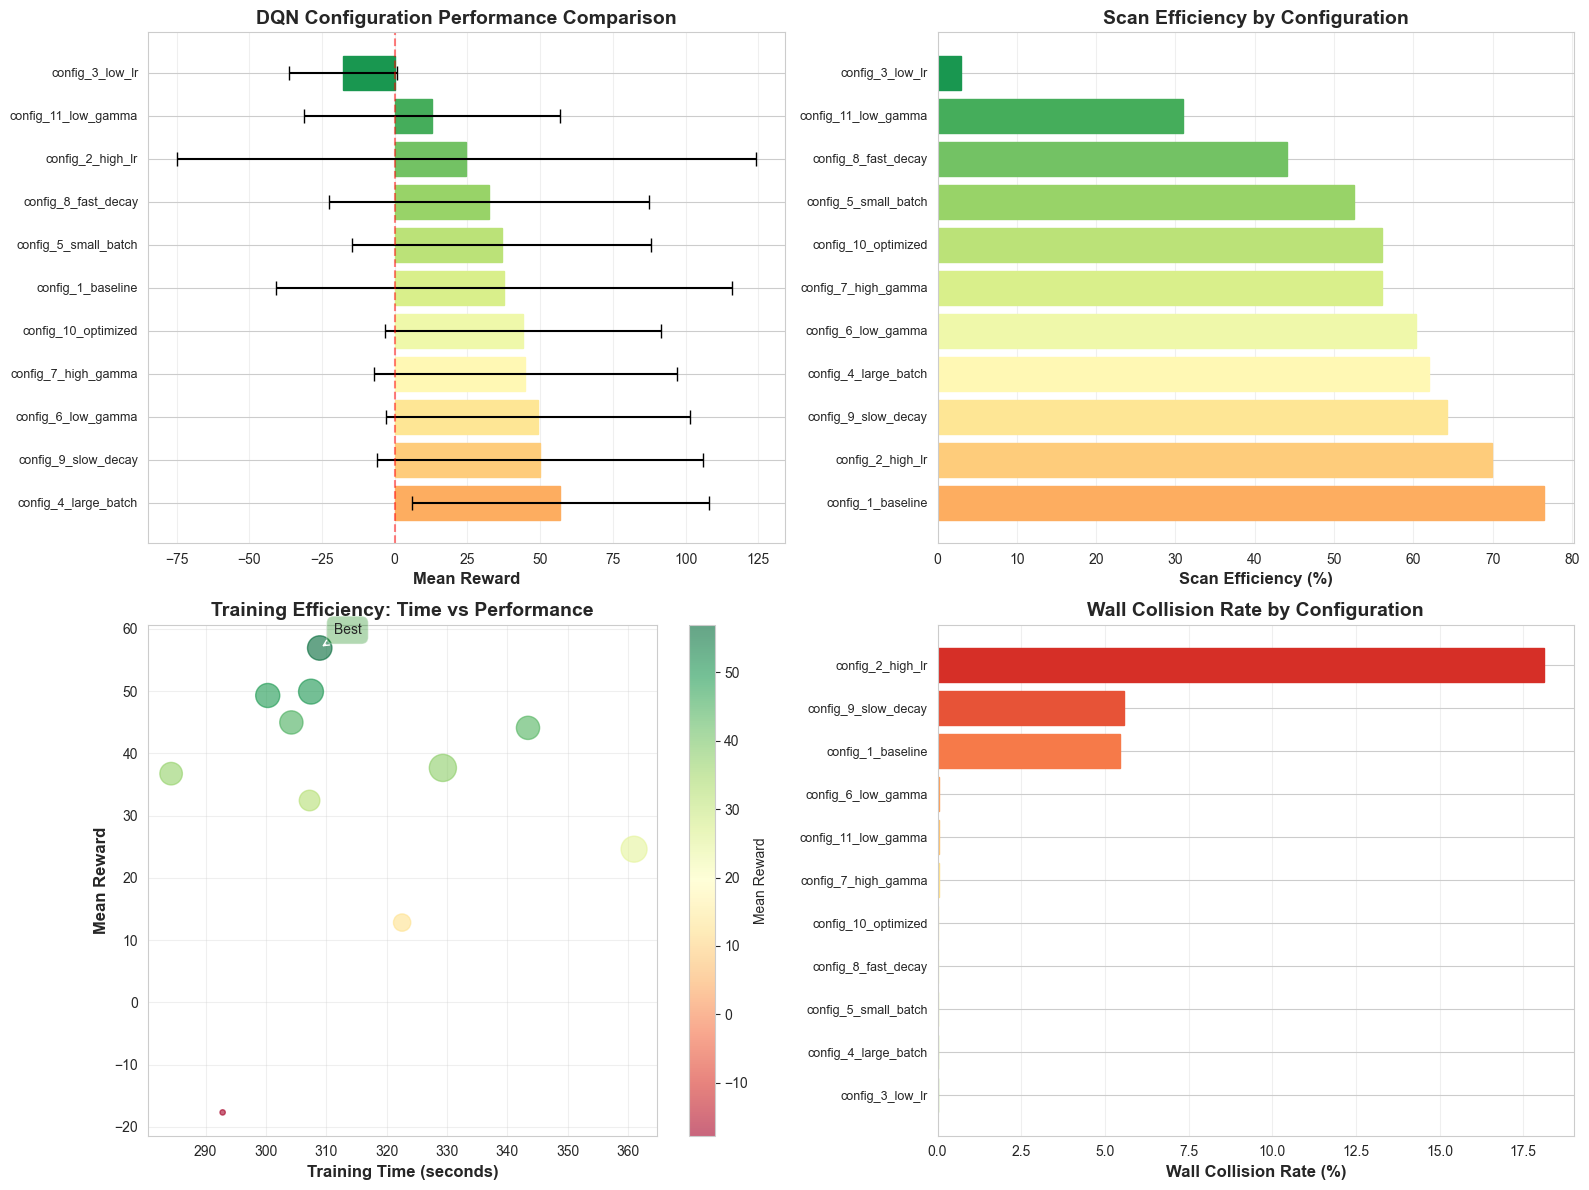

In [9]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 9: Visualize Results - Comparison Plot
# ═══════════════════════════════════════════════════════════════════════
"""
Create comprehensive visualization of results (matching PPO format)
"""

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sort by mean reward
results_sorted = results_df.sort_values('mean_reward', ascending=False)

# 1. Mean Reward Comparison
ax1 = axes[0, 0]
bars = ax1.barh(range(len(results_sorted)), results_sorted['mean_reward'], 
                xerr=results_sorted['std_reward'], capsize=5)
ax1.set_yticks(range(len(results_sorted)))
ax1.set_yticklabels(results_sorted['config_name'], fontsize=9)
ax1.set_xlabel('Mean Reward', fontsize=12, fontweight='bold')
ax1.set_title('DQN Configuration Performance Comparison', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Color bars by performance
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax1.grid(axis='x', alpha=0.3)

# 2. Scan Efficiency (matching PPO)
ax2 = axes[0, 1]
scan_eff_sorted = results_df.sort_values('scan_efficiency', ascending=False)
bars2 = ax2.barh(range(len(scan_eff_sorted)), scan_eff_sorted['scan_efficiency'] * 100)
ax2.set_yticks(range(len(scan_eff_sorted)))
ax2.set_yticklabels(scan_eff_sorted['config_name'], fontsize=9)
ax2.set_xlabel('Scan Efficiency (%)', fontsize=12, fontweight='bold')
ax2.set_title('Scan Efficiency by Configuration', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Color bars
colors2 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars2)))
for bar, color in zip(bars2, colors2):
    bar.set_color(color)

# 3. Training Time vs Performance
ax3 = axes[1, 0]
scatter = ax3.scatter(results_df['training_time'], results_df['mean_reward'], 
                     s=results_df['scan_efficiency']*500, alpha=0.6, 
                     c=results_df['mean_reward'], cmap='RdYlGn')
ax3.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
ax3.set_title('Training Efficiency: Time vs Performance', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# Add labels for best and worst
best_idx = results_df['mean_reward'].idxmax()
worst_idx = results_df['mean_reward'].idxmin()
ax3.annotate('Best', xy=(results_df.loc[best_idx, 'training_time'], 
                         results_df.loc[best_idx, 'mean_reward']),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Colorbar
plt.colorbar(scatter, ax=ax3, label='Mean Reward')

# 4. Wall Collision Rate (matching PPO)
ax4 = axes[1, 1]
wall_coll_sorted = results_df.sort_values('wall_collision_rate', ascending=True)
bars4 = ax4.barh(range(len(wall_coll_sorted)), wall_coll_sorted['wall_collision_rate'] * 100)
ax4.set_yticks(range(len(wall_coll_sorted)))
ax4.set_yticklabels(wall_coll_sorted['config_name'], fontsize=9)
ax4.set_xlabel('Wall Collision Rate (%)', fontsize=12, fontweight='bold')
ax4.set_title('Wall Collision Rate by Configuration', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Color bars (lower is better, so reverse colors)
colors4 = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(bars4)))
for bar, color in zip(bars4, colors4):
    bar.set_color(color)

plt.tight_layout()
plot_path = plots_dir / "dqn_comparison.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Comparison plot saved to {plot_path}")
plt.show()

In [10]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 10: Detailed Analysis - Top 3 Configurations
# ═══════════════════════════════════════════════════════════════════════
"""
Detailed analysis of top 3 performing configurations (matching PPO format)
"""

print("\n" + "="*70)
print("TOP 3 CONFIGURATIONS - DETAILED ANALYSIS")
print("="*70)

top3 = results_df.nlargest(3, 'mean_reward')

for idx, (_, config) in enumerate(top3.iterrows(), 1):
    print(f"\n{'─'*70}")
    print(f"#{idx}: {config['config_name']}")
    print(f"{'─'*70}")
    print(f"Description: {config['description']}")
    print(f"Mean Reward: {config['mean_reward']:.2f} ± {config['std_reward']:.2f}")
    print(f"Avg Episode Length: {config['avg_episode_length']:.1f} steps")
    print(f"Wall Collision Rate: {config['wall_collision_rate']:.2%}")
    print(f"Scan Efficiency: {config['scan_efficiency']:.2%}")
    print(f"Avg Pickup Attempts: {config['avg_pickup_attempts']:.2f}")
    if config['avg_time_to_find_survivor'] is not None:
        print(f"Avg Time to Find Survivor: {config['avg_time_to_find_survivor']:.1f} steps")
    print(f"Survivor Found Count: {config['survivor_found_count']}/100")
    print(f"Training Time: {config['training_time']:.1f} seconds")
    
    if 'hyperparameters' in config and config['hyperparameters']:
        print(f"\nKey Hyperparameters:")
        hparams = config['hyperparameters']
        print(f"  - Learning Rate: {hparams.get('learning_rate', 'N/A')}")
        print(f"  - Batch Size: {hparams.get('batch_size', 'N/A')}")
        print(f"  - Buffer Size: {hparams.get('buffer_size', 'N/A')}")
        print(f"  - Gamma: {hparams.get('gamma', 'N/A')}")
        print(f"  - Exploration Fraction: {hparams.get('exploration_fraction', 'N/A')}")


TOP 3 CONFIGURATIONS - DETAILED ANALYSIS

──────────────────────────────────────────────────────────────────────
#1: config_4_large_batch
──────────────────────────────────────────────────────────────────────
Description: Large Batch - Stable gradients
Mean Reward: 56.91 ± 51.05
Avg Episode Length: 200.0 steps
Wall Collision Rate: 0.00%
Scan Efficiency: 62.00%
Avg Pickup Attempts: 0.62
Avg Time to Find Survivor: 25.9 steps
Survivor Found Count: 62/100
Training Time: 308.9 seconds

Key Hyperparameters:
  - Learning Rate: 0.001
  - Batch Size: 128
  - Buffer Size: 50000
  - Gamma: 0.99
  - Exploration Fraction: 0.2

──────────────────────────────────────────────────────────────────────
#2: config_9_slow_decay
──────────────────────────────────────────────────────────────────────
Description: Slow Decay - Extended exploration
Mean Reward: 49.90 ± 56.14
Avg Episode Length: 200.0 steps
Wall Collision Rate: 5.57%
Scan Efficiency: 64.27%
Avg Pickup Attempts: 0.01
Avg Time to Find Survivor: 1

In [11]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 11: Export Summary for Report
# ═══════════════════════════════════════════════════════════════════════
"""
Create summary tables and statistics for the final report (matching PPO format)
"""

# Summary statistics
summary = {
    'total_configs': len(all_results),
    'best_config': best_config['config_name'],
    'best_mean_reward': float(best_config['mean_reward']),
    'best_scan_efficiency': float(best_config['scan_efficiency']),
    'best_wall_collision_rate': float(best_config['wall_collision_rate']),
    'avg_mean_reward': float(results_df['mean_reward'].mean()),
    'std_mean_reward': float(results_df['mean_reward'].std()),
    'avg_scan_efficiency': float(results_df['scan_efficiency'].mean()),
    'avg_wall_collision_rate': float(results_df['wall_collision_rate'].mean()),
    'total_training_time': float(results_df['training_time'].sum()),
}

# Save summary
summary_path = results_dir / "dqn_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=4)

print("\n" + "="*70)
print("DQN TRAINING SUMMARY")
print("="*70)
for key, value in summary.items():
    if 'rate' in key or 'efficiency' in key:
        if isinstance(value, float) and value < 1:
            print(f"{key.replace('_', ' ').title()}: {value:.2%}")
        else:
            print(f"{key.replace('_', ' ').title()}: {value}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value}")

print(f"\n✓ Summary saved to {summary_path}")


DQN TRAINING SUMMARY
Total Configs: 11
Best Config: config_4_large_batch
Best Mean Reward: 56.9085
Best Scan Efficiency: 62.00%
Best Wall Collision Rate: 0.00%
Avg Mean Reward: 33.78177272727274
Std Mean Reward: 21.131170035475602
Avg Scan Efficiency: 52.31%
Avg Wall Collision Rate: 2.66%
Total Training Time: 3461.718315

✓ Summary saved to c:\Users\HP\Programming\ML\fire_rescue_agent\results\dqn_summary.json
